# look at skewers, turn them into wanted format

In [1]:
import numpy as np
from astropy.io import fits
import pylab as pl
import healpy as hp
from glob import glob

In [2]:
def get_folders(root):
    folder_list = glob(root + "*/", recursive = True)
    return folder_list

def get_file_from_folder(root):
    fname = glob(root + "*", recursive = True)[0]
    return fname

In [3]:
def wave_2_z(wave, emit=1215.67):
    red = (wave-emit)/emit
    return red

In [4]:
# def save fits file:
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)

In [5]:
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers_full_sky/output_files/"
hdu=fits.open(simroot + '13/1375/transmission-16-1375.fits.gz')

In [6]:
wave=hdu[2].data
ra=hdu[1].data['RA']
dec=hdu[1].data['DEC']
z=hdu[1].data['Z']

In [7]:
emit = 1215.67
red = (wave-emit)/emit

ind = red<3.0

In [8]:
lambda_rf_min=1040
lambda_rf_max=1200

In [9]:
nbin=20
ind = red<3.0
bin_edges = np.linspace(red[ind][0], red[ind][-1], nbin+1)
#print(bin_edges)
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [10]:
print(bin_edges)

[1.85439301 1.91167006 1.96894712 2.02622418 2.08350124 2.1407783
 2.19805536 2.25533242 2.31260948 2.36988654 2.4271636  2.48444066
 2.54171772 2.59899478 2.65627184 2.7135489  2.77082596 2.82810302
 2.88538008 2.94265714 2.9999342 ]


## Compute mean flux ratio:

In [ ]:
# should probably recompute the mean flux with full sky skewers!!

In [10]:
# compute the avg F:

#num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers_full_sky/output_files/"

#N_spectra = 0
mean_spectra = np.zeros(len(red))
tot_weights=0
tot_flux=0
for ii in range(31):
    
    if ii%5 == 0:
        print(f"Working on directory {ii}/")
    
    froot = root + f"{ii}/"
    folder_list = get_folders(froot)
    
    for ffroot in folder_list:
        fname = get_file_from_folder(ffroot)
        hdu=fits.open(fname)
        F=hdu['F_LYA'].data
        wave=hdu[2].data
        zq=hdu[1].data['Z']
        
        in_forest=np.empty(F.shape, dtype=bool)
        for iq in range(len(zq)):
            lambda_obs_min=lambda_rf_min*(1+zq[iq])
            lambda_obs_max=lambda_rf_max*(1+zq[iq])
            in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
           
        # compute the avg of F:
        #mean_flux=np.zeros_like(wave)
        #mean_flux[weights>0]=np.sum(F*in_forest, axis=0)[weights>0]/weights[weights>0]
        tot_weights += np.sum(in_forest, axis=0)
        tot_flux += np.sum(F*in_forest, axis=0)

mean_spectra[tot_weights>0]=tot_flux[tot_weights>0]/tot_weights[tot_weights>0]
print(len(mean_spectra))

Working on directory 0/
Working on directory 5/
Working on directory 10/
Working on directory 15/
Working on directory 20/
Working on directory 25/
Working on directory 30/
15150


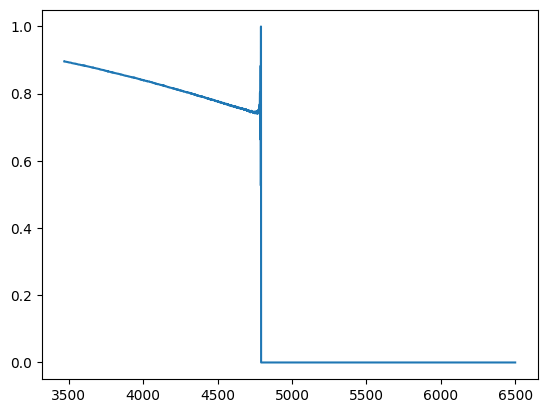

In [11]:
pl.plot(wave,mean_spectra)

In [12]:
# save this:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
np.savetxt(saveroot + "mean_F.txt", np.c_[wave, mean_spectra])

# Get delta_F

In [11]:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"
mean_spectra = np.loadtxt(saveroot + "mean_F.txt")

# Compute deltaF for one skewer:

In [21]:
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers_full_sky/output_files/"
hdu=fits.open(simroot + '13/1375/transmission-16-1375.fits.gz')

wave=hdu[2].data
emit = 1215.67
lambda_rf_min=1040
lambda_rf_max=1200
red = (wave-emit)/emit
F = hdu['F_LYA'].data
zq=hdu[1].data['Z']
in_forest=np.empty(F.shape, dtype=bool)
for iq in range(len(zq)):
    lambda_obs_min=lambda_rf_min*(1+zq[iq])
    lambda_obs_max=lambda_rf_max*(1+zq[iq])
    in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)

In [15]:
print(zq[0])

2.8438148


In [40]:
print(lambda_rf_max*(1+3))

4800


In [11]:
tot_pix = np.sum(in_forest,axis=1)
print(len(tot_pix[tot_pix==0]))

221


148
348
348
348
348
348
349
348
348
142


/tmp/ipykernel_217913/2245032674.py:4: RuntimeWarning: divide by zero encountered in divide
  pl.plot(wave,(F/mean_spectra[:,1]-1)*in_forest[kk].astype(int),label=r'Ly$\alpha$')
/tmp/ipykernel_217913/2245032674.py:4: RuntimeWarning: invalid value encountered in multiply
  pl.plot(wave,(F/mean_spectra[:,1]-1)*in_forest[kk].astype(int),label=r'Ly$\alpha$')
/tmp/ipykernel_217913/2245032674.py:15: RuntimeWarning: divide by zero encountered in divide
  delta = (hdu['F_LYA'].data[kk]/mean_spectra[:,1]-1)*in_forest[kk].astype(int)
/tmp/ipykernel_217913/2245032674.py:15: RuntimeWarning: invalid value encountered in multiply
  delta = (hdu['F_LYA'].data[kk]/mean_spectra[:,1]-1)*in_forest[kk].astype(int)


Text(0.5, 0, 'Redshift')

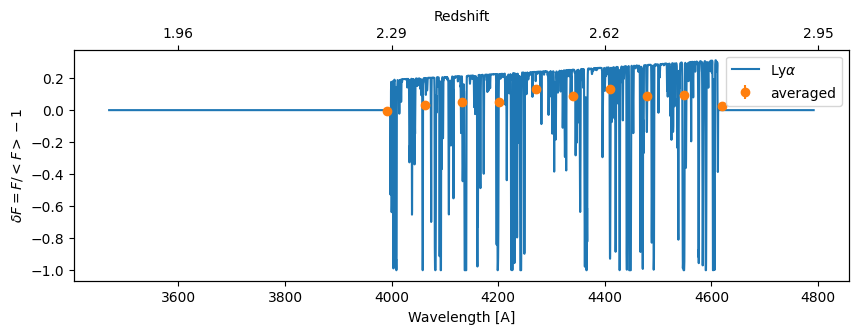

In [18]:
fig, axs = pl.subplots(1,1,figsize=[10,3])
kk = 0
F = hdu['F_LYA'].data[kk]#[ind]
pl.plot(wave,(F/mean_spectra[:,1]-1)*in_forest[kk].astype(int),label=r'Ly$\alpha$')
#plt.plot(wave,hdu['F_LYB'].data[0],label=r'Ly$\beta$')
pl.xlabel('Wavelength [A]')
pl.ylabel('$\\delta F = F/ <F>-1$')

# compute the averaged spectra:
bin_tag = np.digitize(red, bin_edges)
for kk in range(1):
    avg_skewers = np.zeros(nbin)
    error = np.zeros(nbin)
    weight = in_forest[kk].astype(int)
    delta = (hdu['F_LYA'].data[kk]/mean_spectra[:,1]-1)*in_forest[kk].astype(int)
    for ii in range(nbin):
        useind = bin_tag == ii+1
        if np.sum(weight[useind])!=0:
            avg_skewers[ii] = np.sum(delta[useind])/np.sum(weight[useind])
            error[ii] = np.std(delta[useind])/np.sqrt(sum(weight[useind]))
            print(np.sum(weight[useind]))
        else:
            avg_skewers[ii] = np.nan
    plot_ind = ~np.isnan(avg_skewers)
    pl.errorbar((bin_cen[plot_ind]+1)*emit, avg_skewers[plot_ind], yerr=error[plot_ind], 
                fmt='o',label="averaged")
pl.legend()
    
ax2 = axs.twiny()
ax2.set_xlim(axs.get_xlim())
new_loc = np.array([3600, 4000, 4400, 4800])
ax2.set_xticks(new_loc)
new_x = np.round(wave_2_z(new_loc),2)
ax2.set_xticklabels(new_x)
ax2.set_xlabel("Redshift")
#pl.xlabel("redshift")
#pl.ylabel("$\\delta F$")

In [19]:
print(np.mean(avg_skewers[plot_ind]))

0.06912800780399761


## check against Laura's code:

In [17]:
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/Delta/"
delta_F = fits.open(simroot + 'delta-1375.fits.gz')

delta_F[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   32 / width of table in bytes                        
NAXIS2  =                  795 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'LOGLAM  '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'DELTA   '           / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE3  = 'WEIGHT  '        

In [68]:
zq[1], hdu[1].data['RA'][1], hdu[1].data['DEC'][1]

(2.955055, 123.72545, 9.069099)

In [72]:
hdu[1].data['MOCKID']

array([870000004, 870000005, 870000009, ..., 870016568, 870016574,
       870016580], dtype='>i8')

In [18]:
wavelength_log = delta_F[1].data['LOGLAM']
delta_l = delta_F[1].data['DELTA']
weight_l = delta_F[1].data['WEIGHT']
cont_l = delta_F[1].data['CONT']

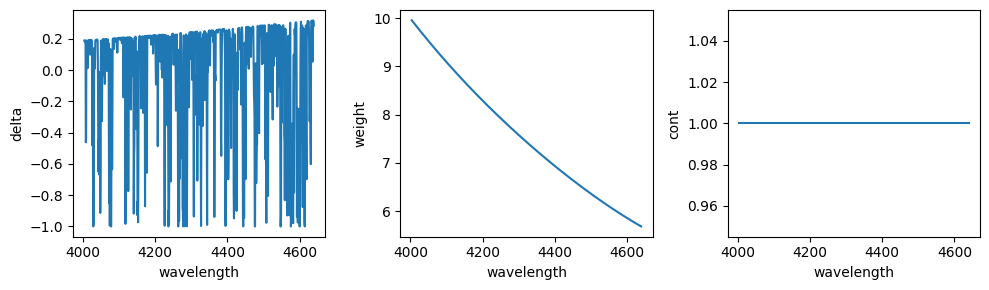

In [19]:
fig,axarr=pl.subplots(1,3,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(10**wavelength_log, delta_l)
pl.xlabel("wavelength")
pl.ylabel("delta")

pl.sca(axarr[1])
pl.plot(10**wavelength_log, weight_l)
pl.xlabel("wavelength")
pl.ylabel("weight")

pl.sca(axarr[2])
pl.plot(10**wavelength_log, cont_l)
pl.xlabel("wavelength")
pl.ylabel("cont")

pl.tight_layout()

/tmp/ipykernel_1662472/1803443009.py:6: RuntimeWarning: divide by zero encountered in divide
  pl.plot(wave[in_forest[0]],(F/mean_spectra[:,1]-1)[in_forest[0]], alpha=0.2, label="computed mask")


Text(0, 0.5, 'delta')

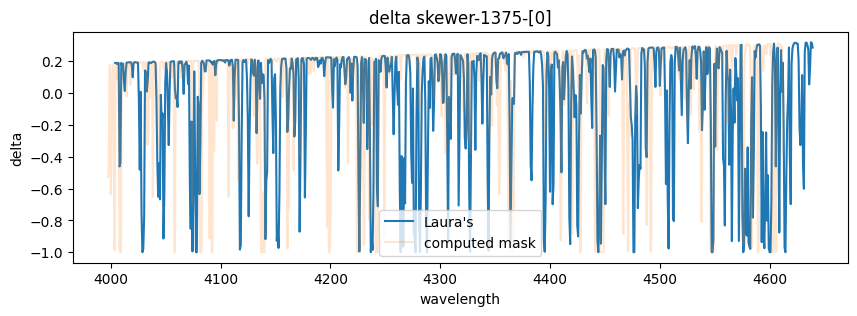

In [22]:
fig,axarr=pl.subplots(1,1,figsize=[10,3])
pl.plot(10**wavelength_log, delta_l, label="Laura's")
# the bit in forest:
kk = 0
F = hdu['F_LYA'].data[kk]
pl.plot(wave[in_forest[0]],(F/mean_spectra[:,1]-1)[in_forest[0]], alpha=0.2, label="computed mask")
pl.legend()
pl.title("delta skewer-1375-[0]")
pl.xlabel("wavelength")
pl.ylabel("delta")

In [27]:
# the mask range is quite different:
print(wave[in_forest[0]][0], wave[in_forest[0]][-1])
print(10**wavelength_log[0],10**wavelength_log[-1])

print(lambda_rf_min*(1+zq[0]), lambda_rf_max*(1+zq[0]))
print(lambda_rf_min*(1+2.84954857826233), lambda_rf_max*(1+2.84954857826233))

3997.6 4612.4
4003.999999999998 4639.2
3997.5674438476562 4612.577819824219
4003.530521392823 4619.458293914796


4003.999999999998 4639.2


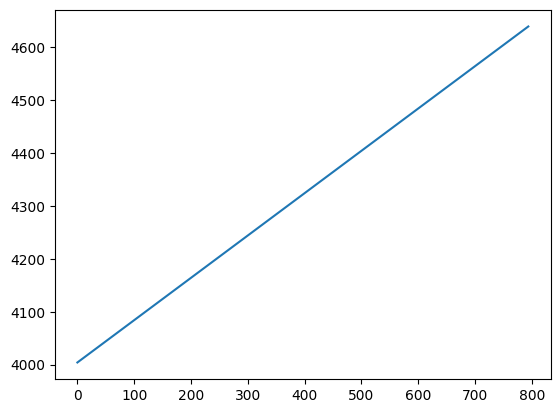

In [39]:
# check mask, check binning:
pl.plot(10**wavelength_log)
# okay so it is uniformly sampled
# same resolution as the original one?
print(10**wavelength_log.min(), 10**wavelength_log.max())

In [40]:
ind = (wave>=10**wavelength_log.min())&(wave<=10**wavelength_log.max())
print(len(wave[ind]))

3177


### save catalog:

In [20]:
#num = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,27,28,30]
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers_full_sky/output_files/"

In [15]:
lambda_rf_min=1040
lambda_rf_max=1200

In [22]:
nbin=20
ind = red<3.0
bin_edges = np.linspace(red[ind][0], red[ind][-1], nbin+1)
#print(bin_edges)
bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
bin_tag = np.digitize(red, bin_edges)

# save the binedges and bins
saveroot = "/pscratch/sd/q/qhang/desi-lya/delta_F/"
fname = saveroot + "zbins.txt"
np.savetxt(fname, np.c_[bin_edges, np.append(bin_cen, 0)])

In [23]:
bin_cen, bin_cen[1]-bin_cen[0]

(array([1.88303154, 1.94030859, 1.99758565, 2.05486271, 2.11213977,
        2.16941683, 2.22669389, 2.28397095, 2.34124801, 2.39852507,
        2.45580213, 2.51307919, 2.57035625, 2.62763331, 2.68491037,
        2.74218743, 2.79946449, 2.85674155, 2.91401861, 2.97129567]),
 0.05727705955505358)

In [23]:
nbin

20

In [41]:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"

for mm in range(1,31):
    froot = root + f"{mm}/"
    folder_list = get_folders(froot)
    savename = saveroot + f"delta_F/pixgroup_{mm}.fits"
    data_holder={}
    
    for ffroot in folder_list:
        fname = get_file_from_folder(ffroot)
        
        # now get delta_F, redshiftbin, ra, and dec: 
        hdu=fits.open(fname)
        ra=hdu[1].data['RA']
        dec=hdu[1].data['DEC']
        zq=hdu[1].data['Z']
        
        # get mask:
        F = hdu['F_LYA'].data
        in_forest=np.empty(F.shape, dtype=bool)
        for iq in range(len(zq)):
            lambda_obs_min=lambda_rf_min*(1+zq[iq])
            lambda_obs_max=lambda_rf_max*(1+zq[iq])
            in_forest[iq]=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
        
        avg_skewers = np.zeros((nbin,len(ra)))
        num_pix = np.zeros((nbin,len(ra)))
        weight = in_forest.astype(int)
        delta = (F/mean_spectra[:,1][None,:]-1)*in_forest.astype(int)
        
        for ii in range(nbin):
            # apply in_forest:
            useind = bin_tag == ii+1
            #norm = mean_spectra[useind,1]
            avg_skewers[ii,:] = np.sum(delta[:,useind],axis=1)/np.sum(weight[:,useind],axis=1)
            num_pix[ii,:] = np.sum(weight[:,useind],axis=1)
            # for points outside of the weight,flag them
            ind_inf = np.isinf(avg_skewers[ii,:])
            ind_nan = np.isnan(avg_skewers[ii,:])
            avg_skewers[ii,ind_inf] = -99
            avg_skewers[ii,ind_nan] = -99
            #zeroind = np.sum(weight[:,useind],axis=1)==0
            #avg_skewers[ii,zeroind] = np.nan
        
        avg_skewers = avg_skewers.T
        num_pix = num_pix.T
        # now construct the catalogue:
        ram = np.outer(ra,np.ones(nbin))
        decm = np.outer(dec,np.ones(nbin))
        zsampbin = np.outer(np.ones(len(ra)),bin_cen)
        zsamptag = np.outer(np.ones(len(ra)),np.arange(len(bin_cen)))
        
        remove_ind = avg_skewers!=-99
        #remove_ind = (np.ones(len(avg_skewers))).astype(bool)
        
        if ffroot == folder_list[0]:
            data_holder["DELTA_F"] = avg_skewers[remove_ind]
            data_holder["NPIX"] = num_pix[remove_ind]
            data_holder["RA"] = ram[remove_ind]
            data_holder["DEC"] = decm[remove_ind]
            data_holder["Z"] = zsampbin[remove_ind]
            data_holder["Z_BIN"] = zsamptag[remove_ind]
        else:
            data_holder["DELTA_F"] = np.append(data_holder["DELTA_F"], avg_skewers[remove_ind])
            data_holder["NPIX"] = np.append(data_holder["NPIX"], num_pix[remove_ind])
            data_holder["RA"] = np.append(data_holder["RA"], ram[remove_ind])
            data_holder["DEC"] = np.append(data_holder["DEC"], decm[remove_ind])
            data_holder["Z"] = np.append(data_holder["Z"], zsampbin[remove_ind])
            data_holder["Z_BIN"] = np.append(data_holder["Z_BIN"], zsamptag[remove_ind])
        
    print("Number of objects: ", len(data_holder["DELTA_F"]))
    save_catalog_to_fits(savename, data_holder)
    print(f"saved: {savename}")

/tmp/ipykernel_217913/1138364921.py:29: RuntimeWarning: divide by zero encountered in divide
  delta = (F/mean_spectra[:,1][None,:]-1)*in_forest.astype(int)
/tmp/ipykernel_217913/1138364921.py:29: RuntimeWarning: invalid value encountered in divide
  delta = (F/mean_spectra[:,1][None,:]-1)*in_forest.astype(int)
/tmp/ipykernel_217913/1138364921.py:29: RuntimeWarning: invalid value encountered in multiply
  delta = (F/mean_spectra[:,1][None,:]-1)*in_forest.astype(int)
/tmp/ipykernel_217913/1138364921.py:35: RuntimeWarning: invalid value encountered in divide
  avg_skewers[ii,:] = np.sum(delta[:,useind],axis=1)/np.sum(weight[:,useind],axis=1)


Number of objects:  1225384
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_1.fits
Number of objects:  1228178
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_2.fits
Number of objects:  1226575
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_3.fits
Number of objects:  1221637
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_5.fits
Number of objects:  1232102
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_6.fits
Number of objects:  1212745
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_7.fits
Number of objects:  1231781
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_8.fits
Number of objects:  1221470
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_9.fits
Number of objects:  1225749
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_10.fits
Number of objects:  1227400
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_12.fits
Number of objects:  1222742
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_13.fits
Number of objects:

In [27]:
# load this file to see if things work:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F/pixgroup_0.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =              1214613 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'DELTA_F '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'NPIX    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'RA      '        

9.068263752937484e-05


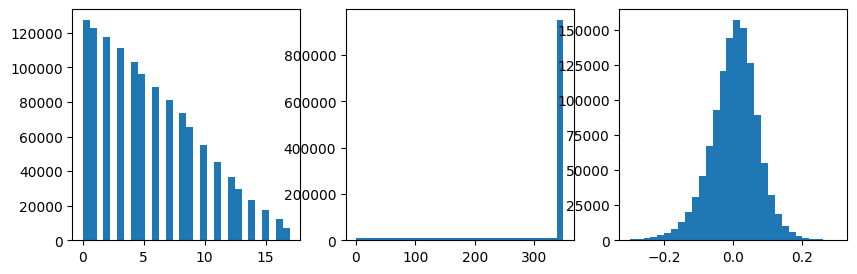

In [39]:
print(np.mean(fin[1].data["DELTA_F"]))
fig,axarr=pl.subplots(1,3,figsize=[10,3])
pl.sca(axarr[0])
cc=pl.hist(fin[1].data["Z_BIN"],bins=30)
pl.sca(axarr[1])
cc=pl.hist(fin[1].data["NPIX"],bins=30)
pl.sca(axarr[2])
cc=pl.hist(fin[1].data["DELTA_F"],range=[-0.3,0.3],bins=30)

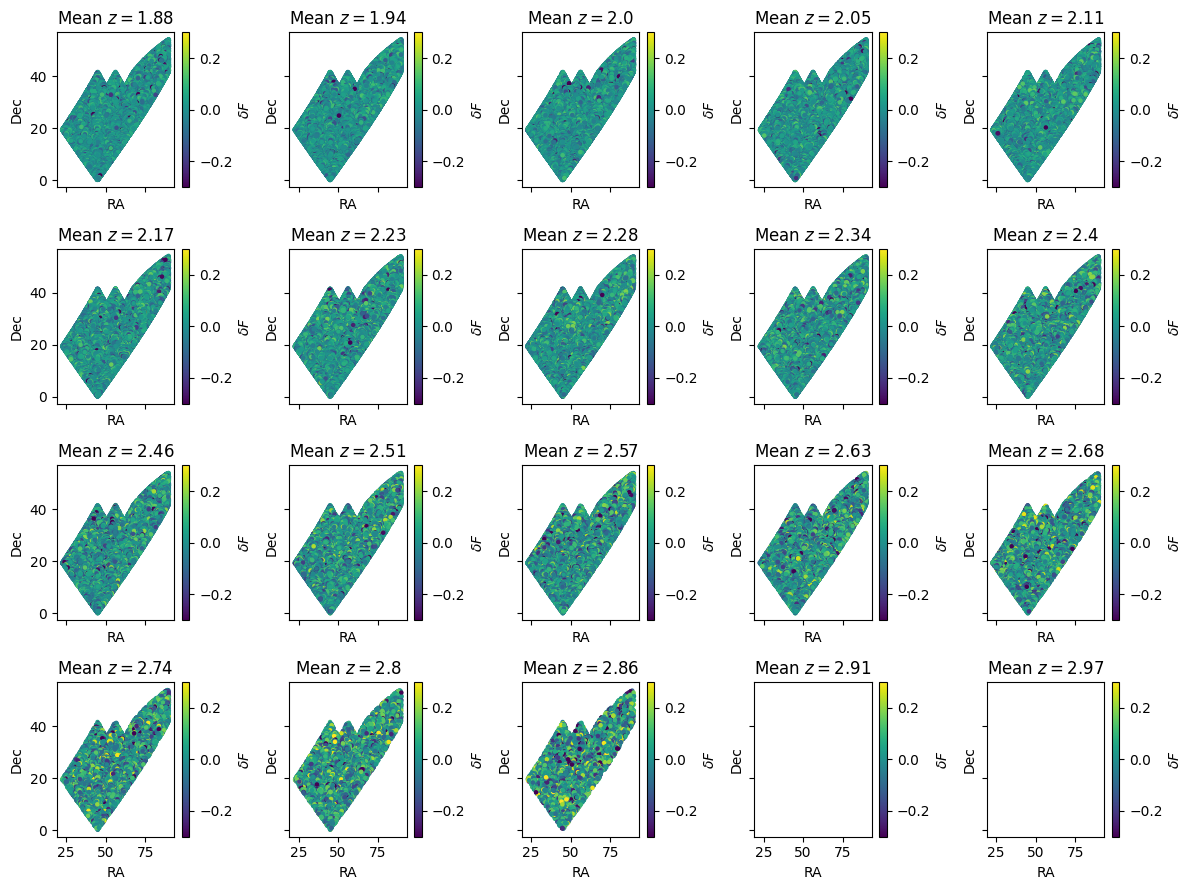

In [35]:
# now let's pick some bins and look at the distirbution:
fig,axarr=pl.subplots(4,5,figsize=[12,9],sharex=True,sharey=True)

z_bin = fin[1].data["Z_BIN"]
ra=fin[1].data["RA"]
dec=fin[1].data["DEC"]

#axarr[1,2].axis("off")

for ii in range(4):
    for jj in range(5):
        kk = (ii*5+jj)
        pl.sca(axarr[ii,jj])
        use = z_bin==kk
        #use *= data_holder["DLETA_F"]!=0
        pl.scatter(ra[use], dec[use],c=delta_f[use],
                  vmax=0.3,vmin=-0.3,s=5)
        pl.colorbar(label="$\\delta F$")
        pl.title(f"Mean $z = {round(bin_cen[kk], 2)}$")
        pl.xlabel("RA")
        pl.ylabel("Dec")
        
pl.tight_layout()

## combine pixelgroup

In [10]:
data_holder={}
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/"
# make a combined catalogue, let's load in first two redshift bins:
for ii in range(31):
    fname = root + f"pixgroup_{ii}.fits"
    fin = fits.open(fname)
    
    for key in fin[1].columns.names:
        if ii == 0:
            data_holder[key] = fin[1].data[key]
        else:
            data_holder[key] = np.append(data_holder[key], fin[1].data[key])
            
# save fits:
fname = root + "comb_pixgroup.fits"
save_catalog_to_fits(fname, data_holder)

37621504
0.00010526828262202284


Text(0.5, 0, 'delta_f')

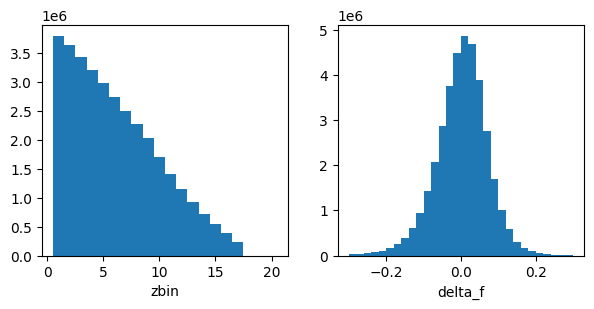

In [13]:
# check this:
fin = fits.open(root + "comb_pixgroup.fits")
print(len(fin[1].data['RA']))

#distribution of delta, redshift, etc.:
print(np.mean(fin[1].data["DELTA_F"]))
fig,axarr=pl.subplots(1,2,figsize=[7,3])
pl.sca(axarr[0])
cc=pl.hist(fin[1].data["Z_BIN"],bins=20,range=[0.5,20.5])
pl.xlabel("zbin")
pl.sca(axarr[1])
cc=pl.hist(fin[1].data["DELTA_F"],range=[-0.3,0.3],bins=30)
pl.xlabel("delta_f")

### footprint

In [19]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']

nside = 128
npix = int(12*nside**2)
pix = hp.ang2pix(nside,
                     np.radians(90 - dec),
                     np.radians(ra))
n = np.bincount(pix, minlength=npix)

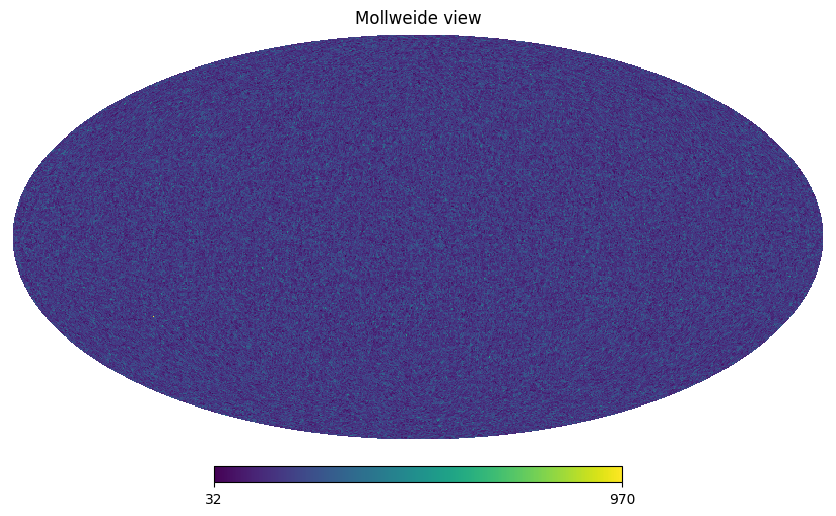

In [20]:
hp.mollview(n)
if(0):
    hp.write_map(f"lya_counts-nside-{nside}.fits", lya_counts)

### check QSO redshift distribution:

In [12]:
l_max_cat = (1+bin_edges[17])*lambda_rf_max
print(l_max_cat)

4593.723621368408


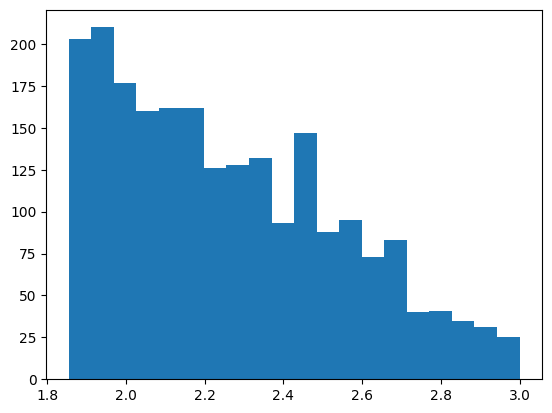

In [13]:
fname = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/skewers_full_sky/output_files/0/0/transmission-16-0.fits.gz"

fin = fits.open(fname)
zq = fin[1].data['Z']
cc = pl.hist(zq,bins=bin_edges)

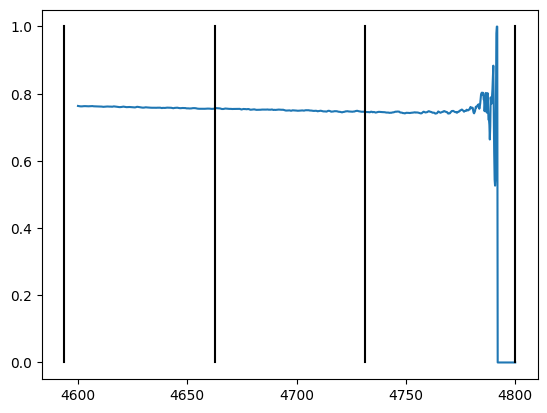

In [16]:
# okay check these samples, see why they don't get assigned a redshift bin:
ind2 = (mean_spectra[:,0]>=4600)&(mean_spectra[:,0]<=4800)
pl.plot(mean_spectra[ind2,0], mean_spectra[ind2,1])

# plot where are the bins:
for ii in range(17,21):
    lam = (bin_edges[ii]+1)*lambda_rf_max
    pl.plot([lam,lam], [0,1],'k-')

In [34]:
# what's the highest redshift here?
print((4800-emit)/emit, bin_edges[17:])
print((wave[mean_spectra[:,1]>0][-1]-emit)/emit)

2.948439954921977 [2.82810302 2.88538008 2.94265714 2.9999342 ]
2.9416945426698855


25
394
2.8987556
20 [10 11 12 13 14 15 16 17 18 19]


Text(0.5, 0, 'Redshift')

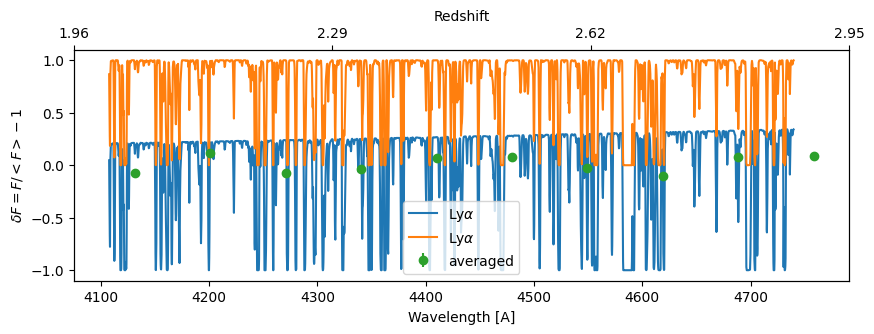

In [25]:
# now run the delta avg code on these high z QSOs:
wave=fin[2].data
emit = 1215.67
lambda_rf_min=1040
lambda_rf_max=1200
red = (wave-emit)/emit
highzind = np.where(zq>bin_edges[19])[0]
print(len(highzind))

iq = highzind[8]
print(iq)
lambda_obs_min=lambda_rf_min*(1+zq[iq])
lambda_obs_max=lambda_rf_max*(1+zq[iq])
in_forest=np.logical_and(wave > lambda_obs_min, wave < lambda_obs_max)
in_forest*=mean_spectra[:,1]>0

fig, axs = pl.subplots(1,1,figsize=[10,3])
F = fin['F_LYA'].data[iq,:]
pl.plot(wave[in_forest],F[in_forest]/mean_spectra[in_forest,1]-1,label=r'Ly$\alpha$')
pl.plot(wave[in_forest],F[in_forest],label=r'Ly$\alpha$')
pl.xlabel('Wavelength [A]')
pl.ylabel('$\\delta F = F/ <F>-1$')


# compute the averaged spectra:
bin_tag = np.digitize(red[in_forest], bin_edges)
print(red[in_forest].max())
avg_skewers = np.zeros(nbin)
error = np.zeros(nbin)
weight = in_forest.astype(int)[in_forest]
delta = F[in_forest]/mean_spectra[in_forest,1]-1
print(nbin, np.unique(bin_tag))


for ii in range(nbin):
    useind = bin_tag == ii+1
    if np.sum(weight[useind])>0:
        avg_skewers[ii] = np.sum(delta[useind])/np.sum(weight[useind])
        error[ii] = np.std(delta[useind])/np.sqrt(sum(weight[useind]))
    else:
        avg_skewers[ii] = -99
#plot_ind = ~np.isnan(avg_skewers)
plot_ind = avg_skewers>-99
pl.errorbar((bin_cen[plot_ind]+1)*emit, avg_skewers[plot_ind], yerr=error[plot_ind], 
            fmt='o',label="averaged")
pl.legend()

ax2 = axs.twiny()
ax2.set_xlim(axs.get_xlim())
new_loc = np.array([3600, 4000, 4400, 4800])
ax2.set_xticks(new_loc)
new_x = np.round(wave_2_z(new_loc),2)
ax2.set_xticklabels(new_x)
ax2.set_xlabel("Redshift")
#pl.xlabel("redshift")
#pl.ylabel("$\\delta F$")

In [35]:
avg_skewers

array([-9.90000000e+01, -9.90000000e+01, -9.90000000e+01, -9.90000000e+01,
       -9.90000000e+01, -9.90000000e+01, -9.90000000e+01, -9.90000000e+01,
       -9.90000000e+01, -7.82409819e-02,  1.14816364e-01, -7.19236993e-02,
       -3.29895532e-02,  6.70161326e-02,  8.27842846e-02, -2.17404483e-02,
       -9.99651469e-02,  7.49417893e-02,  8.80113335e-02, -9.90000000e+01])

# Grab existing delta catalogue and create a catalogue with the same binning for testing

The existing delta are computed over uniform pixel grid, so we can simply combine them;

In [48]:
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/Delta/"
# grab all file names in this directory:
fname_list = glob(simroot + "*.fits.gz", recursive = True)
print("Total files to go through: ", len(fname_list))

Total files to go through:  1490


In [41]:
saveroot = "/pscratch/sd/q/qhang/desi-lya/"

data_holder={}
for ii, fname in enumerate(fname_list[:1]):
    
    if ii%100 == 0:
        print(f"working on {ii}/{len(fname_list)}...")

    delta_F = fits.open(fname)

    # grab all objects in this file:
    nobj = len(delta_F)-1

    for jj in range(nobj):
        
        wavelength_log = delta_F[jj+1].data['LOGLAM']
        delta_l = delta_F[jj+1].data['DELTA']
        #weight_l = delta_F[1].data['WEIGHT']
        #cont_l = delta_F[1].data['CONT']
        
        # for each, bin in redshift: 
        objred = (10**wavelength_log-emit)/emit
        # compute the averaged spectra:
        bin_tag = np.digitize(objred, bin_edges)
        
        hduh = delta_F[jj+1].header
        ra = hduh['RA']
        dec = hduh['DEC']

        # now bin:
        for kk in range(nbin):
            useind = bin_tag == kk+1
            if len(objred[useind])>0:
                num_pix = len(objred[useind])
                deltaF = np.sum(delta_l[useind])/num_pix
                
                if 'RA' not in list(data_holder.keys()):
                    data_holder['RA'] = ra
                    data_holder['DEC'] = dec
                    data_holder['Z_BIN'] = kk+1
                    data_holder['DELTA_F'] = deltaF
                    data_holder['NPIX'] = num_pix

                else: 
                    data_holder['RA'] = np.append(data_holder['RA'], ra)
                    data_holder['DEC'] = np.append(data_holder['DEC'], dec)
                    data_holder['Z_BIN'] = np.append(data_holder['Z_BIN'], kk+1)
                    data_holder['DELTA_F'] = np.append(data_holder['DELTA_F'], deltaF)
                    data_holder['NPIX'] = np.append(data_holder['NPIX'], num_pix)
                    
                    
print("Number of objects: ", len(data_holder["DELTA_F"]))
savename = saveroot + "delta_F/delta-laura.fits"
save_catalog_to_fits(savename, data_holder)
print(f"saved: {savename}")

Total files to go through:  1491
working on 0/1491...
Number of objects:  11140
saved: /pscratch/sd/q/qhang/desi-lya/delta_F/delta-laura.fits


(array([0.000e+00, 1.023e+03, 1.144e+03, 1.179e+03, 1.097e+03, 1.028e+03,
        9.230e+02, 8.540e+02, 7.840e+02, 6.960e+02, 5.900e+02, 4.780e+02,
        3.770e+02, 3.140e+02, 2.440e+02, 1.780e+02, 1.290e+02, 6.900e+01,
        3.200e+01, 1.000e+00]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <BarContainer object of 20 artists>)

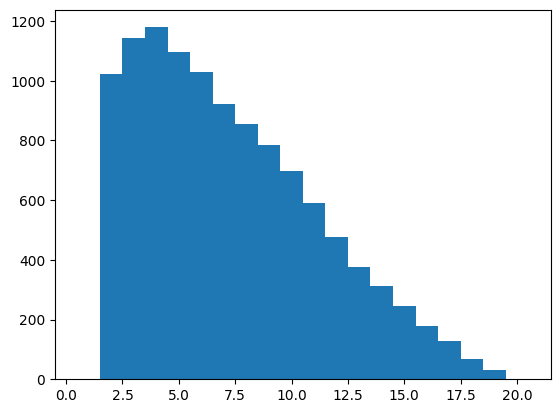

In [46]:
pl.hist(data_holder['Z_BIN'],bins=20,range=[0.5,20.5])

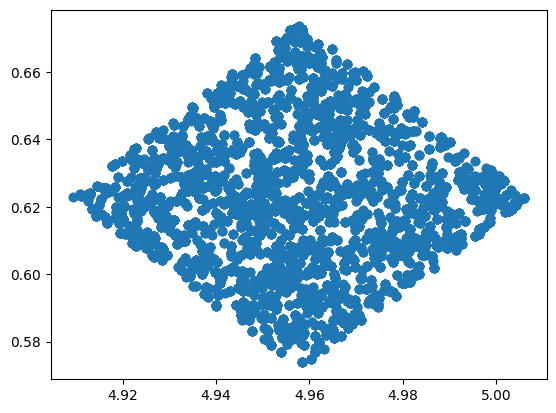

In [49]:
pl.scatter(data_holder['RA'],data_holder['DEC'])

In [15]:
# combine into one file:
data_holder = {}# at different redshift
root = "/pscratch/sd/q/qhang/desi-lya/delta_F/"
# make a combined catalogue, let's load in first two redshift bins:
for ii in range(32):
    fname = root + f"delta-laura-part-{ii}.fits"
    fin = fits.open(fname)
    
    for key in fin[1].columns.names:
        if ii == 0:
            data_holder[key] = fin[1].data[key]
        else:
            data_holder[key] = np.append(data_holder[key], fin[1].data[key])
            
# save fits:
fname = root + "delta-laura-comb.fits"
save_catalog_to_fits(fname, data_holder)

In [17]:
# load and compute mean delta over the catalogue:
fin = fits.open(root + "delta-laura-comb.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =             16618646 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z_BIN   '        

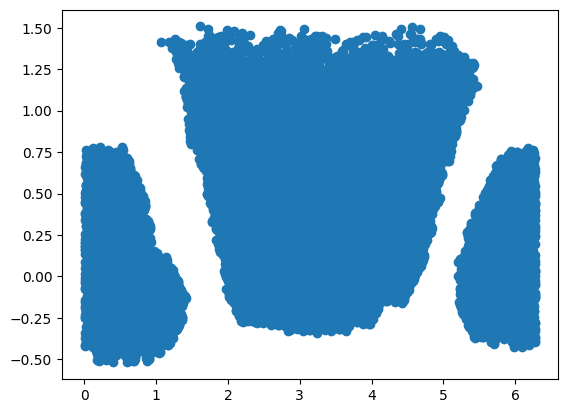

In [18]:
# look at ra, dec distribution:
ra = fin[1].data['RA'][::1000]
dec = fin[1].data['DEC'][::1000]

pl.scatter(ra, dec)

0.00017230616490689408


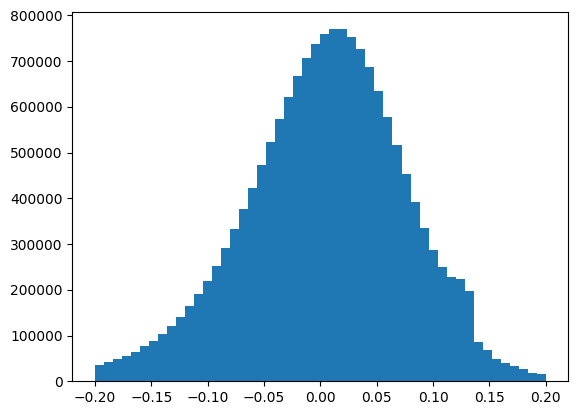

In [22]:
deltaf = fin[1].data['DELTA_F']
cc= pl.hist(deltaf, bins=50, range=[-0.2,0.2])
print(np.mean(deltaf))

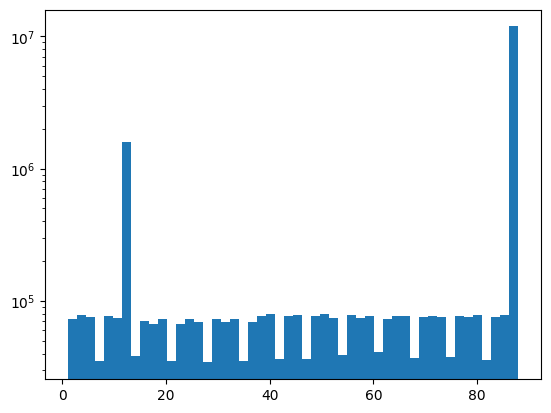

In [24]:
npix = fin[1].data['NPIX']
cc= pl.hist(npix, bins=50)
#print(np.mean(deltaf))
pl.yscale("log")